In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import yaml

torch.set_float32_matmul_precision("medium")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Create Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean/Std R Val 0.4993770122528076 0.3211461007595062
Mean/Std B Val 0.5006996989250183 0.32312172651290894
Mean/Std G Val 0.5003107786178589 0.3227364420890808


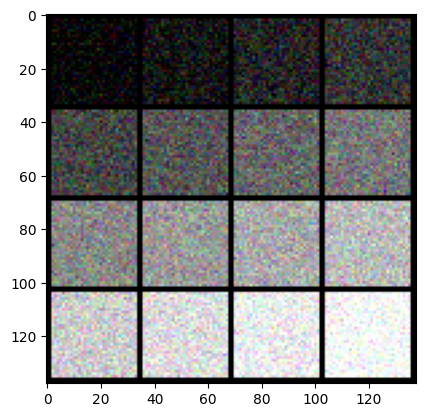

In [2]:
img_dim = (3, 32, 32)

batch_size = 1
N = 16

train_shape = [N, *img_dim]
X = torch.zeros(train_shape).to(device)
gray_values = torch.linspace(0.0, 1.0, N)
X += gray_values.reshape((N, 1, 1, 1)).to(device)
random_noise = torch.randn_like(X) * 0.1  # Noise scale
X += random_noise

overfit_batch = (X, torch.Tensor([-1]))  # Label is not used in train_vae_on_batch
print("Mean/Std R Val", X[:, 0, ...].mean().item(), X[:, 0, ...].std().item())
print("Mean/Std B Val", X[:, 1, ...].mean().item(), X[:, 1, ...].std().item())
print("Mean/Std G Val", X[:, 2, ...].mean().item(), X[:, 2, ...].std().item())


plt.imshow(make_grid(X, nrow=4).permute(1, 2, 0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


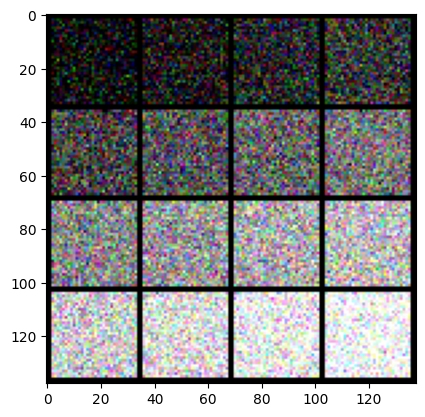

In [3]:
from pytorch_lightning import LightningDataModule
import torch
from torchvision.datasets import VisionDataset


class GrayValuesDataset(VisionDataset):
    def __init__(self, N, img_dim):
        super(GrayValuesDataset, self).__init__()
        self.N = N
        self.img_dim = img_dim
        self.data = torch.zeros([N, *img_dim])
        self.data += torch.linspace(0.0, 1.0, N).reshape((N, 1, 1, 1))
        random_noise = torch.randn_like(self.data) * 0.2  # Noise scale
        self.data += random_noise

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.data[idx], -1


class GrayLT(LightningDataModule):

    def __init__(self, N, img_dim, batch_size):
        super().__init__()
        self.N = N
        self.img_dim = img_dim
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.dataset = GrayValuesDataset(self.N, self.img_dim)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size)


plt.imshow(
    make_grid(GrayValuesDataset(16, (3, 32, 32)).data, nrow=4)
    .permute(1, 2, 0)
    .cpu()
    .detach()
    .numpy()
)

# Load VAE model

In [4]:
from pytorch_lightning.loggers import TensorBoardLogger
from models import *
from experiment import VAEXperiment
import shutil
import os

config_path = "configs/gray_vq_vae.yaml"
with open(config_path, "r") as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

print(config)

tag = ""
config_tagged = config_path.split("/")[-1].replace(".yaml", f"{tag}.yaml")
print(config_tagged)


tb_logger = TensorBoardLogger(
    save_dir=config["logging_params"]["save_dir"],
    name=config["logging_params"]["name"] + tag,
)

log_path = tb_logger.log_dir
print(log_path)
os.makedirs(log_path, exist_ok=True)
shutil.copy(config_path, log_path + "/" + config_tagged)

# For reproducibility
# seed_everything(config["exp_params"]["manual_seed"], True)

model = vae_models[config["model_params"]["name"]](**config["model_params"])
experiment = VAEXperiment(model, config["exp_params"])

{'model_params': {'name': 'VQVAE', 'in_channels': 3, 'embedding_dim': 128, 'num_embeddings': 512, 'img_size': 32, 'beta': 0.01}, 'exp_params': {'LR': 0.001, 'weight_decay': 0.0, 'scheduler_gamma': 0.9999, 'kld_weight': 0.00025, 'manual_seed': 1265}, 'trainer_params': {'accelerator': 'gpu', 'devices': 1, 'max_epochs': 50000, 'check_val_every_n_epoch': 1000}, 'logging_params': {'save_dir': 'logs/', 'name': 'VQVAE_gray'}}
gray_vq_vae.yaml
logs/VQVAE_gray/version_1


In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from pytorch_lightning.plugins import DDPPlugin
from pathlib import Path
import os

runner = Trainer(
    logger=tb_logger,
    callbacks=[
        LearningRateMonitor(),
        ModelCheckpoint(
            save_top_k=2,
            dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
            monitor="VQ_Loss",
            save_last=True,
        ),
    ],
    log_every_n_steps=1,
    # strategy=DDPPlugin(find_unused_parameters=False),
    **config["trainer_params"],
)


Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
print(f"======= Training {config['model_params']['name']} =======")
runner.fit(experiment, datamodule=GrayLT(N, img_dim, N))

======= Training VQVAE =======


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | VQVAE | 9.9 M 
--------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.638    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ducha/mambaforge/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/ducha/mambaforge/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50000` reached.
